## Figure 2. Adenosine Base Editor screen of full length of BCR-ABL.

In [1]:
import os
import shutil, subprocess, time
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
from pydeseq2.dds import DeseqDataSet
from pydeseq2.dds import DefaultInference
from pydeseq2.ds import DeseqStats
from collections import Counter

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### The following code is an exmaple of how the adenosine deaminase base editor screen of the full length BCR-ABL protein was processed

You can skip it if you prefer to look at down stream analysis

In [8]:
NEW_Screen_names = []

for file in os.listdir():
    if ".fq.gz" in file:
        subprocess.call(['cutadapt', '-g', 'TGGAAAGGACGAAACACC...GTTTTAGAGCTAGAAAT', '-j', '20', '-m', '17', '-M', '23',
                     file , '-o', file[:-6] + ".fq"])
        NEW_Screen_names.append(file[:-6])

This is cutadapt 3.5 with Python 3.10.12
Command line parameters: -g TGGAAAGGACGAAACACC...GTTTTAGAGCTAGAAAT -j 20 -m 17 -M 23 HEK_Virus1_CKDL230044599-1A_22GFCTLT3_L8_1.fq.gz -o HEK_Virus1.fq
Processing reads on 20 cores in single-end mode ...
Finished in 44.63 s (2 µs/read; 34.47 M reads/minute).

=== Summary ===

Total reads processed:              25,641,709
Reads with adapters:                24,697,729 (96.3%)

== Read fate breakdown ==
Reads that were too short:           1,027,357 (4.0%)
Reads that were too long:            1,060,243 (4.1%)
Reads written (passing filters):    23,554,109 (91.9%)

Total basepairs processed: 3,846,256,350 bp
Total written (filtered):    483,070,777 bp (12.6%)

=== Adapter 3 ===

Sequence: TGGAAAGGACGAAACACC...GTTTTAGAGCTAGAAAT; Type: linked; Length: 18+17; 5' trimmed: 24697729 times; 3' trimmed: 24697729 times

Minimum overlap: 3+3
No. of allowed errors:
1-9 bp: 0; 10-18 bp: 1

No. of allowed errors:
1-9 bp: 0; 10-17 bp: 1

Overview of removed sequ

#### Run this function inside the working directory:
bowtie-build gBCRABL_Control_sgRNA.fasta BCR_ABL_Control_sgRNA

The next part is to align the trimmed reads to a ref file of all sgRNAs in the BCR-ABL Screen

In [10]:
for d in NEW_Screen_names:
    subprocess.call(['bowtie', '-n', '2', '-p', '20', '-q', '--norc', '--best', '-l', '17','-x', 'BCR_ABL_Control_sgRNA', d + '.fq', d + '.txt'])

# reads processed: 23554109
# reads with at least one alignment: 20833280 (88.45%)
# reads that failed to align: 2720829 (11.55%)
Reported 20833280 alignments
# reads processed: 11060102
# reads with at least one alignment: 9756380 (88.21%)
# reads that failed to align: 1303722 (11.79%)
Reported 9756380 alignments
# reads processed: 10108467
# reads with at least one alignment: 8918432 (88.23%)
# reads that failed to align: 1190035 (11.77%)
Reported 8918432 alignments
# reads processed: 14547589
# reads with at least one alignment: 12833613 (88.22%)
# reads that failed to align: 1713976 (11.78%)
Reported 12833613 alignments
# reads processed: 4818746
# reads with at least one alignment: 4246707 (88.13%)
# reads that failed to align: 572039 (11.87%)
Reported 4246707 alignments


In [11]:
sgNames_fasta = open("gBCRABL_Control_sgRNA.fasta", "r").read().splitlines()[::2]
sgNames = [sg[1:] for sg in sgNames_fasta]
ScreenDF = pd.DataFrame(sgNames, columns=['sgName'])
ScreenDF.head()

,sgName
0,BCRABL_3149
1,BCRABL_332
2,BCRABL_467
3,BCRABL_691
4,BCRABL_335


In [ ]:
#GET COUNTS FROM ALIGNMENT
for d in NEW_Screen_names:
    Bowtie_output = open((d+".txt"), "r").read().split('\t')
    sgRNA_IDs = Bowtie_output[2::7] #sgRNA ID list
    sg_Frequency = Counter(sgRNA_IDs)
    sgCounts = []
    for sgN in sgNames:
        sgCounts.append(sg_Frequency[sgN])
    ScreenDF[d] = sgCounts
    print([d, len(sgRNA_IDs)])

In [13]:
ScreenDF.to_csv('NEW_BCRABL_Screen_Counts.csv')

##  This section is for DESeq2 Fold Change Analysis

In [2]:
ScreenDF = pd.read_csv('NEW_BCRABL_Screen_Counts.csv')

In [3]:
ScreenDF

,Unnamed: 0,sgName,A1_D0,A1_D6,A1_D8,A1_Imat_D6,A2_D0,A2_D6,A2_D8,A2_Imat_D6,A3_D0,A3_D6,A3_D8,A3_Imat_D6,C1_D0,C1_D6,C1_D8,C1_Imat_D6,C2_D0,C2_D6,C2_D8,C2_Imat_D6,C3_D0,C3_D6,C3_D8,C3_Imat_D6,HEK_Virus1,HEK_Virus2,n1_D0,n1_D6,n1_D8,n2_D0,n2_D6,n2_D8,n3_D0,n3_D6,n3_D8,C1_Imat_D6_PSU,C3_D0_PSU,HEK2_PSU
0,0,BCRABL_3149,771,329,845,452,758,215,963,735,1139,442,1238,192,1203,237,851,0,340,236,709,1108,0,247,1141,20,2239,0,400,244,670,475,409,664,501,458,880,217,98,421
1,1,BCRABL_332,1672,429,1356,158,1390,444,2243,1263,2395,672,2245,525,2044,317,1411,0,578,431,1658,1042,0,414,2434,4119,3619,0,764,450,1991,905,793,1490,753,745,1506,72,160,776
2,2,BCRABL_467,195,82,204,43,206,31,96,0,240,119,268,6,243,18,171,0,53,36,199,32,0,24,192,23,455,0,80,86,356,65,63,104,135,65,185,0,22,78
3,3,BCRABL_691,1338,396,1111,290,1222,344,1244,203,1550,651,1389,148,1371,290,1166,0,438,360,1147,2102,0,226,1401,183,2561,0,566,364,1197,540,354,916,706,671,1006,322,123,510
4,4,BCRABL_335,2628,782,2465,612,2589,737,3082,1484,3997,1376,4492,2486,3435,630,2728,0,1121,911,2900,3452,1,818,5403,901,6244,0,1360,921,3459,1528,1512,3373,1567,1278,2222,389,279,1390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5019,5019,BCR2_1127,1978,602,1641,246,1731,484,1767,813,2706,963,2276,822,2042,403,1512,0,970,779,2436,2991,0,488,2721,384,3411,0,1097,587,2227,1002,891,1937,1063,1004,1595,318,179,693
5020,5020,BCR2_1128,2756,754,2016,418,2403,596,2765,896,2998,1037,3441,826,3084,602,2670,0,916,807,3051,5892,0,612,4318,1439,4060,0,1360,743,3229,1264,999,2148,1386,1277,2452,1517,235,1012
5021,5021,BCR2_1129,1344,369,1066,419,1177,309,1462,189,1926,607,1578,161,1561,432,1392,0,454,348,1061,2203,0,269,1675,204,2127,0,603,344,1376,622,680,1205,619,595,1062,280,118,438
5022,5022,BCR2_1130,714,136,558,57,629,104,462,108,845,254,757,52,652,61,223,0,159,89,292,254,0,76,481,36,5267,0,1169,693,2269,1273,1011,2058,1256,994,1978,5,51,1129


In [4]:
NEW_Norm = ScreenDF[ScreenDF.columns[1:]].set_index('sgName').div(ScreenDF.set_index('sgName').sum(axis=1), axis=0)

In [5]:
ScreenDF2 = ScreenDF[ScreenDF.columns[1:]].set_index('sgName').T

In [6]:
meta = pd.read_csv('NEW_Screen_Condition_Matrix.csv').set_index('Samples')
meta.iloc[20] = 'CBE_D0' #for consistency puropose as DESeq2 models dispersion acrosss all samples

In [7]:
inference = DefaultInference(n_cpus=20)
dds = DeseqDataSet(
    counts=ScreenDF2,
    metadata=meta,
    design_factors="Condition",
    refit_cooks=True,
    n_cpus=20)
dds.deseq2()

/home/ivan/.local/lib/python3.10/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import

In [8]:
DESeq2_Normed_Counts = pd.DataFrame(dds.layers['normed_counts'], index=ScreenDF2.index, columns=ScreenDF2.columns).T

In [9]:
DESeq2_Normed_Freq = DESeq2_Normed_Counts.div(DESeq2_Normed_Counts.sum(axis=0), axis=1)

In [10]:
DESeq2_Normed_Freq.to_csv('DESeq2_Normed_Freq_NEW_Screen.csv')

In [11]:
DESeq2_Normed_Freq['D0'] = DESeq2_Normed_Freq[['HEK2_PSU', 'HEK_Virus1']].mean(1)
DESeq2_Normed_Freq['D9'] = DESeq2_Normed_Freq[['A1_D0', 'A2_D0', 'A3_D0']].mean(1)

In [12]:
DESeq2_Normed_Freq.to_csv('DESeq2_Normed_Freq2400609.csv')

In [13]:
DESeq2_Normed_Freq['Virus'] = DESeq2_Normed_Freq[['HEK_Virus1', 'HEK2_PSU']].mean(1)
DESeq2_Normed_Freq['ABE_D0_1'] = np.log2(DESeq2_Normed_Freq['A1_D0']/DESeq2_Normed_Freq['Virus'])
DESeq2_Normed_Freq['ABE_D0_2'] = np.log2(DESeq2_Normed_Freq['A2_D0']/DESeq2_Normed_Freq['Virus'])
DESeq2_Normed_Freq['ABE_D0_3'] = np.log2(DESeq2_Normed_Freq['A3_D0']/DESeq2_Normed_Freq['Virus'])

/home/ivan/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ivan/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
DESeq2_Normed_Freq[['ABE_D0_1', 'ABE_D0_2', 'ABE_D0_3']].corr('pearson')

,ABE_D0_1,ABE_D0_2,ABE_D0_3
ABE_D0_1,1.000000,0.722270,0.732572
ABE_D0_2,0.722270,1.000000,0.736609
ABE_D0_3,0.732572,0.736609,1.000000


In [15]:
#Test ABE
ABE_D0 = DeseqStats(dds, contrast=["Condition", "ABE-D0", "Virus"])
ABE_D0.summary()

Running Wald tests...
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip pa

Log2 fold change & Wald test p-value: Condition ABE-D0 vs Virus
               baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
sgName                                                                        
BCRABL_3149  248.791403       -0.206713  0.659001 -0.313676  0.753767  0.99996
BCRABL_332   455.385268        0.031389  0.598106  0.052480  0.958146  0.99996
BCRABL_467    42.096879        0.118534  1.018163  0.116419  0.907320  0.99996
BCRABL_691   303.896343        0.200450  0.521125  0.384649  0.700497  0.99996
BCRABL_335   892.230804       -0.023813  0.357494 -0.066611  0.946891  0.99996
...                 ...             ...       ...       ...       ...      ...
BCR2_1127    504.654506        0.397148  0.383866  1.034601  0.300855  0.99996
BCR2_1128    723.992829        0.357630  0.363243  0.984548  0.324846  0.99996
BCR2_1129    323.938953        0.535720  0.533368  1.004410  0.315181  0.99996
BCR2_1130    258.325618       -1.807193  0.444908 -4.061948  0.0000

... done in 0.89 seconds.



In [16]:
ABE_D0.results_df.to_csv('DESeq2_results_ABE_D0.csv')

In [17]:
sns.set_context("paper")

In [18]:
ABE_D0.results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
sgName,,,,,,
BCRABL_3149,248.791403,-0.206713,0.659001,-0.313676,0.753767,0.99996
BCRABL_332,455.385268,0.031389,0.598106,0.052480,0.958146,0.99996
BCRABL_467,42.096879,0.118534,1.018163,0.116419,0.907320,0.99996
BCRABL_691,303.896343,0.200450,0.521125,0.384649,0.700497,0.99996
BCRABL_335,892.230804,-0.023813,0.357494,-0.066611,0.946891,0.99996
...,...,...,...,...,...,...
BCR2_1127,504.654506,0.397148,0.383866,1.034601,0.300855,0.99996
BCR2_1128,723.992829,0.357630,0.363243,0.984548,0.324846,0.99996
BCR2_1129,323.938953,0.535720,0.533368,1.004410,0.315181,0.99996


In [19]:
DESeq2_DF_FC = ABE_D0.results_df.reset_index()
DESeq2_DF_FC['ABE_D0'] = 2**DESeq2_DF_FC['log2FoldChange']

## Distribution Plot

In [20]:
#DESeq2_DF_FC = pd.read_csv('DESeq2_FC_NEW_Screen.csv')
DESeq2_DF_FC = DESeq2_DF_FC.dropna()
#Convert Fold Change to growthrate asssumign WT growth rate
DESeq2_DF_FC['ABE_growthrate'] = np.log(DESeq2_DF_FC['ABE_D0']*np.exp(0.055*9*24))/(9*24)

#Identify the sgRNAs targeting ABL or Control
Library_Dict = {'B':'BCR-ABL', 'C':'Control'}
DESeq2_DF_FC['Library'] = DESeq2_DF_FC['sgName'].str[0].map(Library_Dict)
DESeq2_DF_FC_Control = DESeq2_DF_FC.loc[DESeq2_DF_FC['Library']=='Control']
DESeq2_DF_FC_Control['NT'] = (DESeq2_DF_FC_Control['sgName'].str[:10] == 'Control_NT')
nontargeting = DESeq2_DF_FC_Control.loc[DESeq2_DF_FC_Control['NT']==True, 'ABE_growthrate']
targeting = DESeq2_DF_FC_Control.loc[DESeq2_DF_FC_Control['NT']==False, 'ABE_growthrate']

/tmp/ipykernel_158548/3812861936.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DESeq2_DF_FC_Control['NT'] = (DESeq2_DF_FC_Control['sgName'].str[:10] == 'Control_NT')


In [21]:
import scipy as scipy
scipy.stats.f_oneway(nontargeting, targeting)

F_onewayResult(statistic=36.024549067461535, pvalue=3.068504822982589e-09)

The varaince in the NT and Targeting controls are diffrent. Therefore use targeting controls to better represent the targeting BCR-ABL Library

In [22]:
SD2 =  targeting.mean() - (2*targeting.std())
SD4 =  targeting.mean() - (4*targeting.std())

In [23]:
SD2, SD4

(0.0541397227562014, 0.05289878578054389)

In [24]:
ABE_D0_DF = ABE_D0.results_df
ABE_D0_DF['ABE_growthrate'] = np.log(np.power(2,ABE_D0_DF['log2FoldChange'])*np.exp(0.055*9*24))/(9*24)

#Identify the sgRNAs targeting ABL or Control
Library_Dict = {'B':'BCR-ABL', 'C':'Control_T'}
ABE_D0_DF['Library'] = ABE_D0_DF.index.str[0].map(Library_Dict)
ABE_D0_DF.loc[ABE_D0_DF.index.str[:10] == 'Control_NT', 'Library'] = 'Control_NT'

In [25]:
ABE_D0_DF

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ABE_growthrate,Library
sgName,,,,,,,,
BCRABL_3149,248.791403,-0.206713,0.659001,-0.313676,0.753767,0.99996,0.054337,BCR-ABL
BCRABL_332,455.385268,0.031389,0.598106,0.052480,0.958146,0.99996,0.055101,BCR-ABL
BCRABL_467,42.096879,0.118534,1.018163,0.116419,0.907320,0.99996,0.055380,BCR-ABL
BCRABL_691,303.896343,0.200450,0.521125,0.384649,0.700497,0.99996,0.055643,BCR-ABL
BCRABL_335,892.230804,-0.023813,0.357494,-0.066611,0.946891,0.99996,0.054924,BCR-ABL
...,...,...,...,...,...,...,...,...
BCR2_1127,504.654506,0.397148,0.383866,1.034601,0.300855,0.99996,0.056274,BCR-ABL
BCR2_1128,723.992829,0.357630,0.363243,0.984548,0.324846,0.99996,0.056148,BCR-ABL
BCR2_1129,323.938953,0.535720,0.533368,1.004410,0.315181,0.99996,0.056719,BCR-ABL


In [26]:
SD =  ABE_D0_DF.loc[ABE_D0_DF['Library']=='Control_T', 'ABE_growthrate'].std()
mean = ABE_D0_DF.loc[ABE_D0_DF['Library']=='Control_T', 'ABE_growthrate'].mean()
SD2 = mean - 2*SD

In [27]:
SD2

0.0541397227562014

In [28]:
ABE_D0_DF.to_csv('ABE_D0_DF240603.csv')

In [29]:
sgRNA_pred = pd.read_csv('BCRABBL NG sgRNA Predicted Mutagenesis Classed Labeled with Final Class 20240130 2to12.csv')
sgRNA_pred_ABE = sgRNA_pred.loc[(sgRNA_pred['Type']=='ABE')&(sgRNA_pred['RefSeq cDNA']==True)]

In [30]:
BCRABL_trageting_library = sgRNA_pred_ABE['sgName'].drop_duplicates().values
ABE_D0_DF = ABE_D0_DF.reset_index()

In [31]:
ABE_D0_DF_BCRABL = ABE_D0_DF.loc[ABE_D0_DF['sgName'].isin(BCRABL_trageting_library)]

In [32]:
(ABE_D0_DF_BCRABL['ABE_growthrate'] < SD2).value_counts()

ABE_growthrate
False    2728
True      387
Name: count, dtype: int64

<Figure size 660x1650 with 0 Axes>

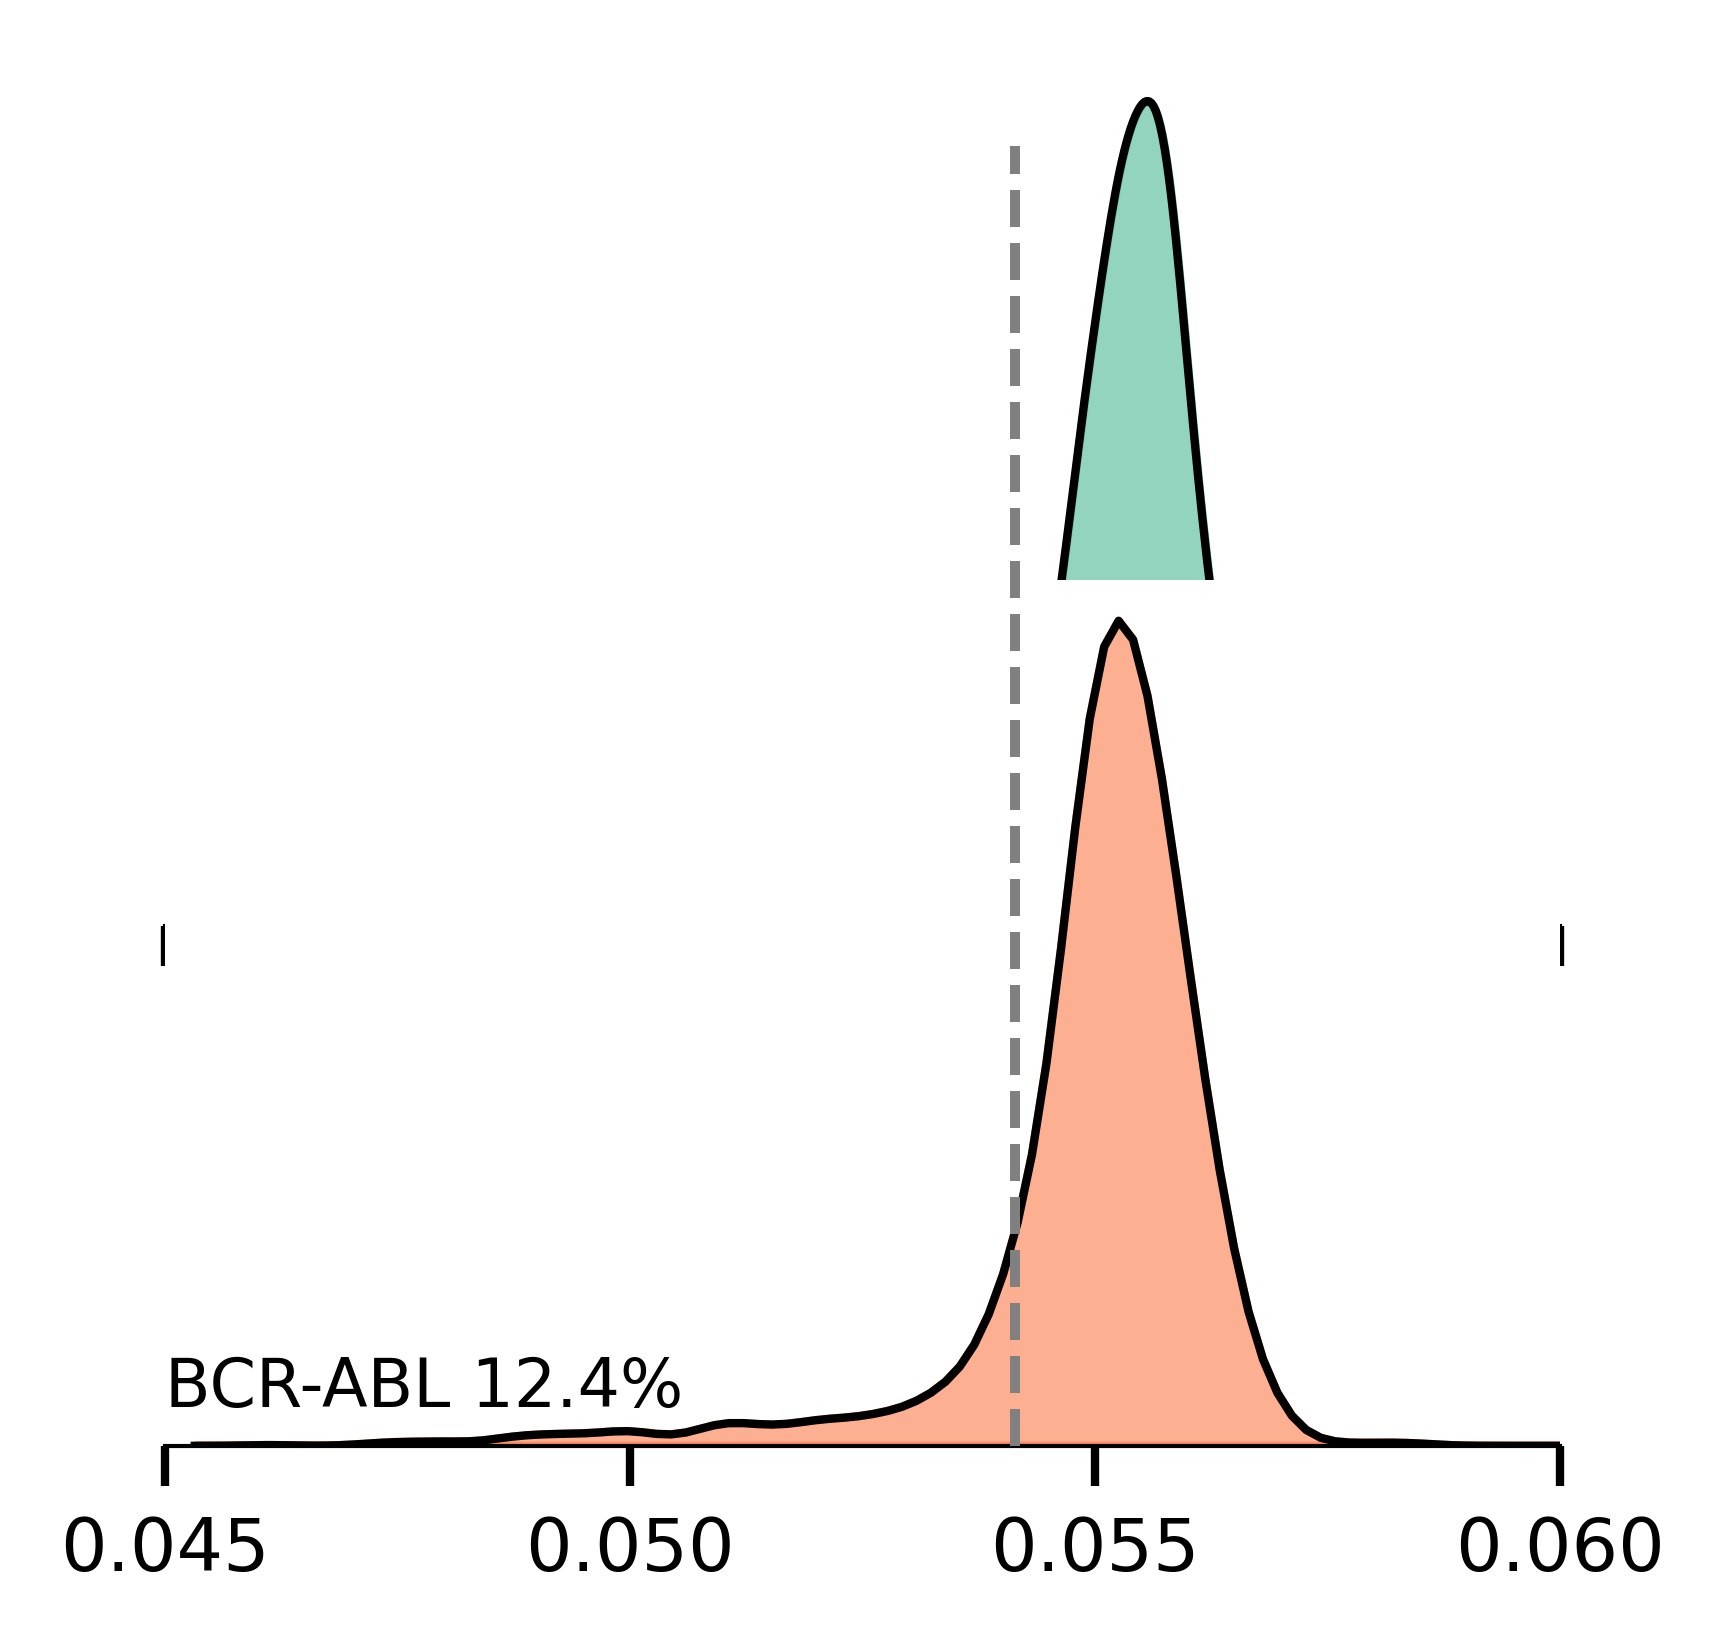

In [33]:
#Updated to exclude NT control 

plt.figure(figsize=(1.1,2.75), dpi=600)
sgRNA_library = [ABE_D0_DF.loc[ABE_D0_DF['Library']=='Control_T', 'ABE_growthrate'],
                ABE_D0_DF_BCRABL['ABE_growthrate']]
sgRNA_library_names = ['Targeting', 'BCR-ABL']

cutoff = SD2
lims = [0.045, 0.06]

sns.set_context("paper")
fig,ax = plt.subplots(2,figsize=(3,3), dpi=600,sharex=True)
for i, library in enumerate(sgRNA_library):
    sns.kdeplot(library,color=sns.color_palette("Set2")[i],ax=ax[i],shade=True,legend=False,clip_on=[0.045,0.06],alpha=0.7,lw=1,zorder=1).set(xlim=lims,ylabel=None)
    sns.kdeplot(library,clip_on=[0.045,0.06],color='black',lw=1,ax=ax[i],legend=False,zorder=1).set(xlim=lims, ylabel=None)
    ax[i].set_title('')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # tidy up plot               
    ax[i].set_xlim(0.045,0.06)
    #ax[i].text(0,0.045,sgRNA_library_names[i],fontsize=6,transform=ax[i].transAxes)
    ax[i].text(0,0.045,sgRNA_library_names[i] + ' ' + str((((sgRNA_library[i] < SD2).sum()/ sgRNA_library[i].count())*100).round(1)) + '%',fontsize=8,transform=ax[i].transAxes)
    ax[i].spines['bottom'].set_linewidth(0.5)

plt.gca().set_xlabel('sgRNA growth rate (hour⁻¹)',fontsize=6) 
plt.gca().axvline(x=SD2,ymin=0,ymax=1.5,linestyle="dashed", color='grey',zorder=3, clip_on=False)
plt.gca().set_xticks([0.045, 0.05,0.055,0.06])
#plt.xticks(fontsize=6)
plt.gca().set_xlabel('sgRNA growth rate (hour⁻¹)',fontsize=6)
sns.despine(top=True,bottom=False,left=True,right=True)

# Set the subplots to overlap
plt.subplots_adjust(hspace=-0.4)

fig.savefig('ABE sgRNA RidgePlot0613.svg',transparent=True,bbox_inches='tight')

In [34]:
sgRNA_pred = pd.read_csv('BCRABBL NG sgRNA Predicted Mutagenesis Classed Labeled with Final Class 20240130 2to12.csv')
sgRNA_pred_ABE = sgRNA_pred.loc[(sgRNA_pred['Type']=='ABE')&(sgRNA_pred['RefSeq cDNA']==True)]
ABE_D0_pred = pd.merge(DESeq2_DF_FC[['sgName', 'ABE_D0']], sgRNA_pred_ABE, on='sgName')
ABE_D0_pred['ABE_growthrate'] = np.log(ABE_D0_pred['ABE_D0']*np.exp(0.055*9*24))/(9*24)
ABE_D0_pred_dedup = ABE_D0_pred[['sgName', 'ABE_growthrate','Mean_AA_Number', 'Final_Class']].drop_duplicates()

In [35]:
ABE_D0_pred[['sgName', 'Final_Class']].drop_duplicates()['Final_Class'].value_counts()

Final_Class
Missense    2871
Silent       244
Name: count, dtype: int64

In [36]:
ABE_D0_DF['Library'].value_counts()

Library
BCR-ABL       4286
Control_NT     565
Control_T      173
Name: count, dtype: int64

### Lollipop Plot

In [37]:
sgRNA_pred = pd.read_csv('BCRABBL NG sgRNA Predicted Mutagenesis Classed Labeled with Final Class 20240130 2to12.csv')
sgRNA_pred_ABE = sgRNA_pred.loc[(sgRNA_pred['Type']=='ABE')&(sgRNA_pred['RefSeq cDNA']==True)]
ABE_D0_pred = pd.merge(DESeq2_DF_FC[['sgName', 'ABE_D0']], sgRNA_pred_ABE, on='sgName')
ABE_D0_pred['ABE_growthrate'] = np.log(ABE_D0_pred['ABE_D0']*np.exp(0.055*9*24))/(9*24)
ABE_D0_pred_dedup = ABE_D0_pred[['sgName', 'ABE_growthrate','Mean_AA_Number', 'Final_Class']].drop_duplicates()
ABE_D0_pred_dedup['Mean_ABL_AA'] = ABE_D0_pred_dedup['Mean_AA_Number']-927+27
ABE_D0_pred_dedup_kinase = ABE_D0_pred_dedup.loc[ABE_D0_pred_dedup['Mean_ABL_AA'].between(237, 500)]

In [38]:
ABE_D0_pred_dedup_kinase_Missesnse = ABE_D0_pred_dedup_kinase.loc[ABE_D0_pred_dedup_kinase['Final_Class']=='Missense']
ABE_D0_pred_dedup_kinase_Silent = ABE_D0_pred_dedup_kinase.loc[ABE_D0_pred_dedup_kinase['Final_Class']=='Silent']

In [39]:
Kinase_Info = [['P-loop', 245,255 , 240, sns.color_palette()[2]], 
               ['',270, 272, 271, sns.color_palette()[3]], 
               ['aC-Helix',279, 293, 291, sns.color_palette()[4]],
               ['A-loop', 381, 409, 395, sns.color_palette()[5]]]

In [40]:
sns.reset_defaults()
%matplotlib inline
import matplotlib.pyplot as plt
sns.set_context('paper')

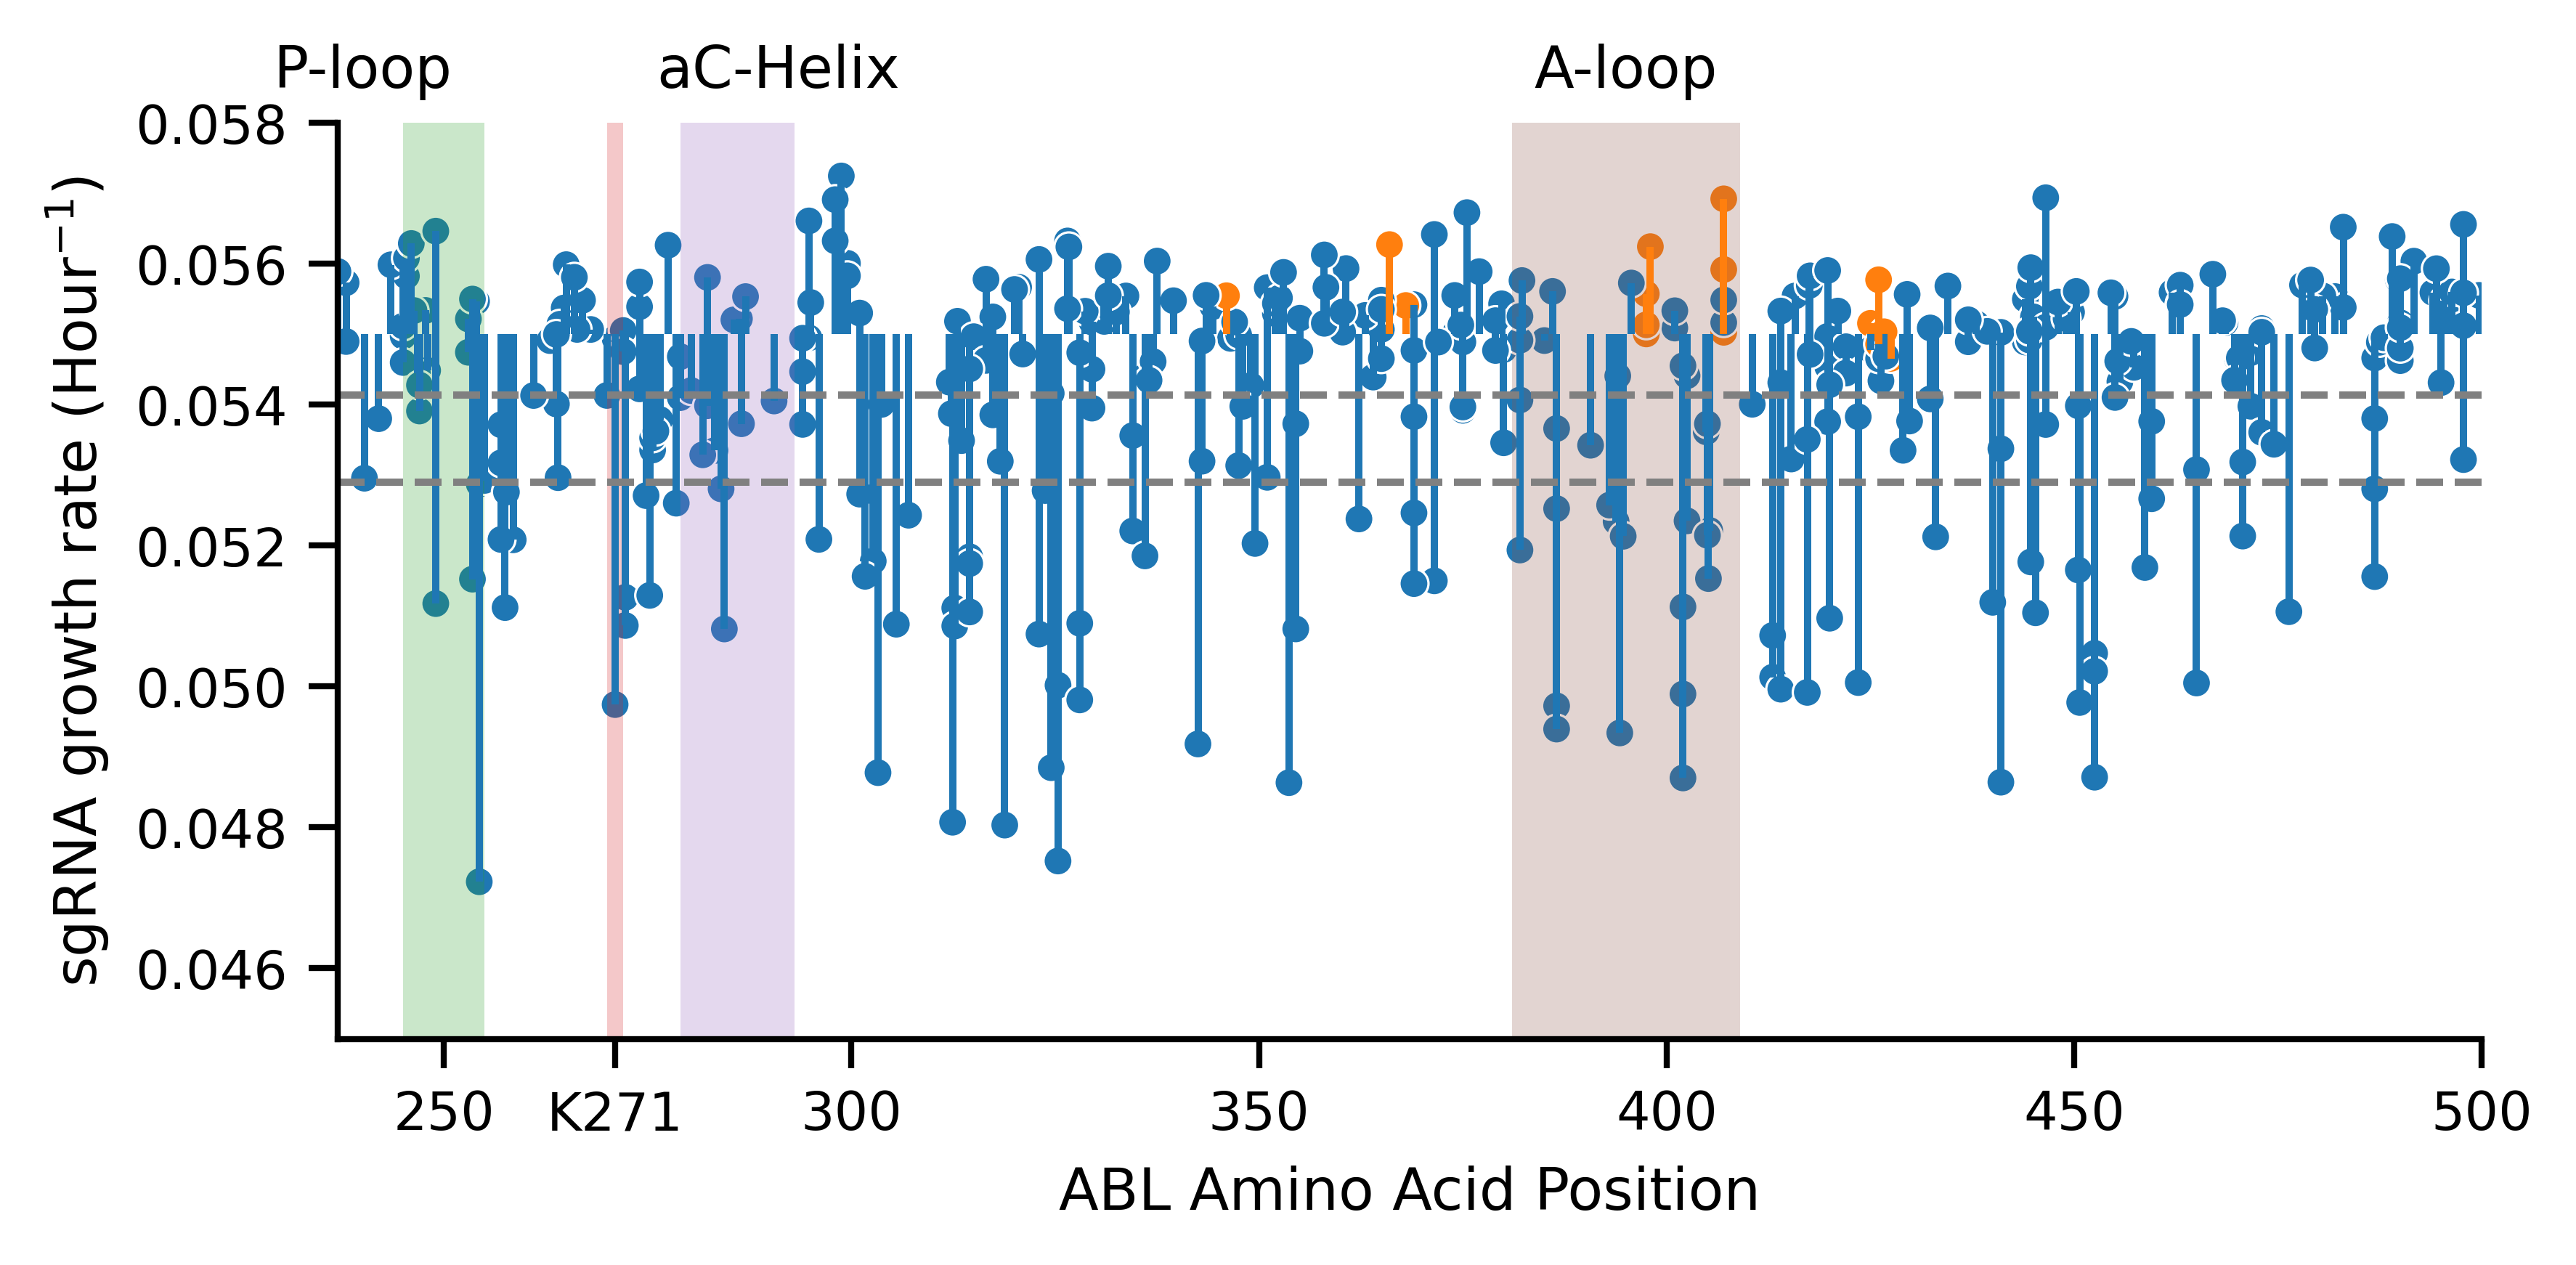

In [41]:
plt.figure(figsize=(6,3), dpi=600)
lollipop = sns.scatterplot(x='Mean_ABL_AA',y='ABE_growthrate',hue='Final_Class', data=ABE_D0_pred_dedup_kinase, legend=False)
lollipop.set(xlabel='ABL Amino Acid Position', ylabel='sgRNA growth rate (Hour$^{-1}$)', ylim=[0.045, 0.058], xlim=[237, 500])
plt.vlines(ABE_D0_pred_dedup_kinase_Missesnse['Mean_ABL_AA'], 0.055, ABE_D0_pred_dedup_kinase_Missesnse['ABE_growthrate'], color=sns.color_palette()[0])
plt.vlines(ABE_D0_pred_dedup_kinase_Silent['Mean_ABL_AA'], 0.055, ABE_D0_pred_dedup_kinase_Silent['ABE_growthrate'], color=sns.color_palette()[1])
plt.hlines(SD2,237, 500, linestyles="--", color='grey')
plt.hlines(SD4,237, 500, linestyles="--", color='grey')
for name, start, end, mid, color in Kinase_Info:
    plt.axvspan(start, end, color=color, alpha=0.25, ec=None)
    lollipop.text(mid, 0.0585, name, horizontalalignment='center')

lollipop.set_xticks([250, 271, 300, 350, 400, 450, 500], [250, 'K271', 300, 350, 400, 450, 500])
sns.despine()
plt.tight_layout()
lollipop.get_figure().savefig("ABE Lollipop 240603.svg" , transparent=True) 

In [42]:
(ABE_D0_pred_dedup_kinase['ABE_growthrate'] < SD2).sum()/(ABE_D0_pred_dedup_kinase['ABE_growthrate'] < SD2).count()

0.37851662404092073

About 38% of kinase targeting sgRNAs deplete below a -2 Z-score of targeting control sgRNA.

In [43]:
ABE_D0_pred_dedup_kinase['Hit'] = ABE_D0_pred_dedup_kinase['ABE_growthrate'] < SD2
ABE_D0_pred_dedup_kinase = ABE_D0_pred_dedup_kinase.loc[ABE_D0_pred_dedup_kinase['Mean_ABL_AA'].between(240,320)]

/tmp/ipykernel_158548/4179319017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABE_D0_pred_dedup_kinase['Hit'] = ABE_D0_pred_dedup_kinase['ABE_growthrate'] < SD2


In [44]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

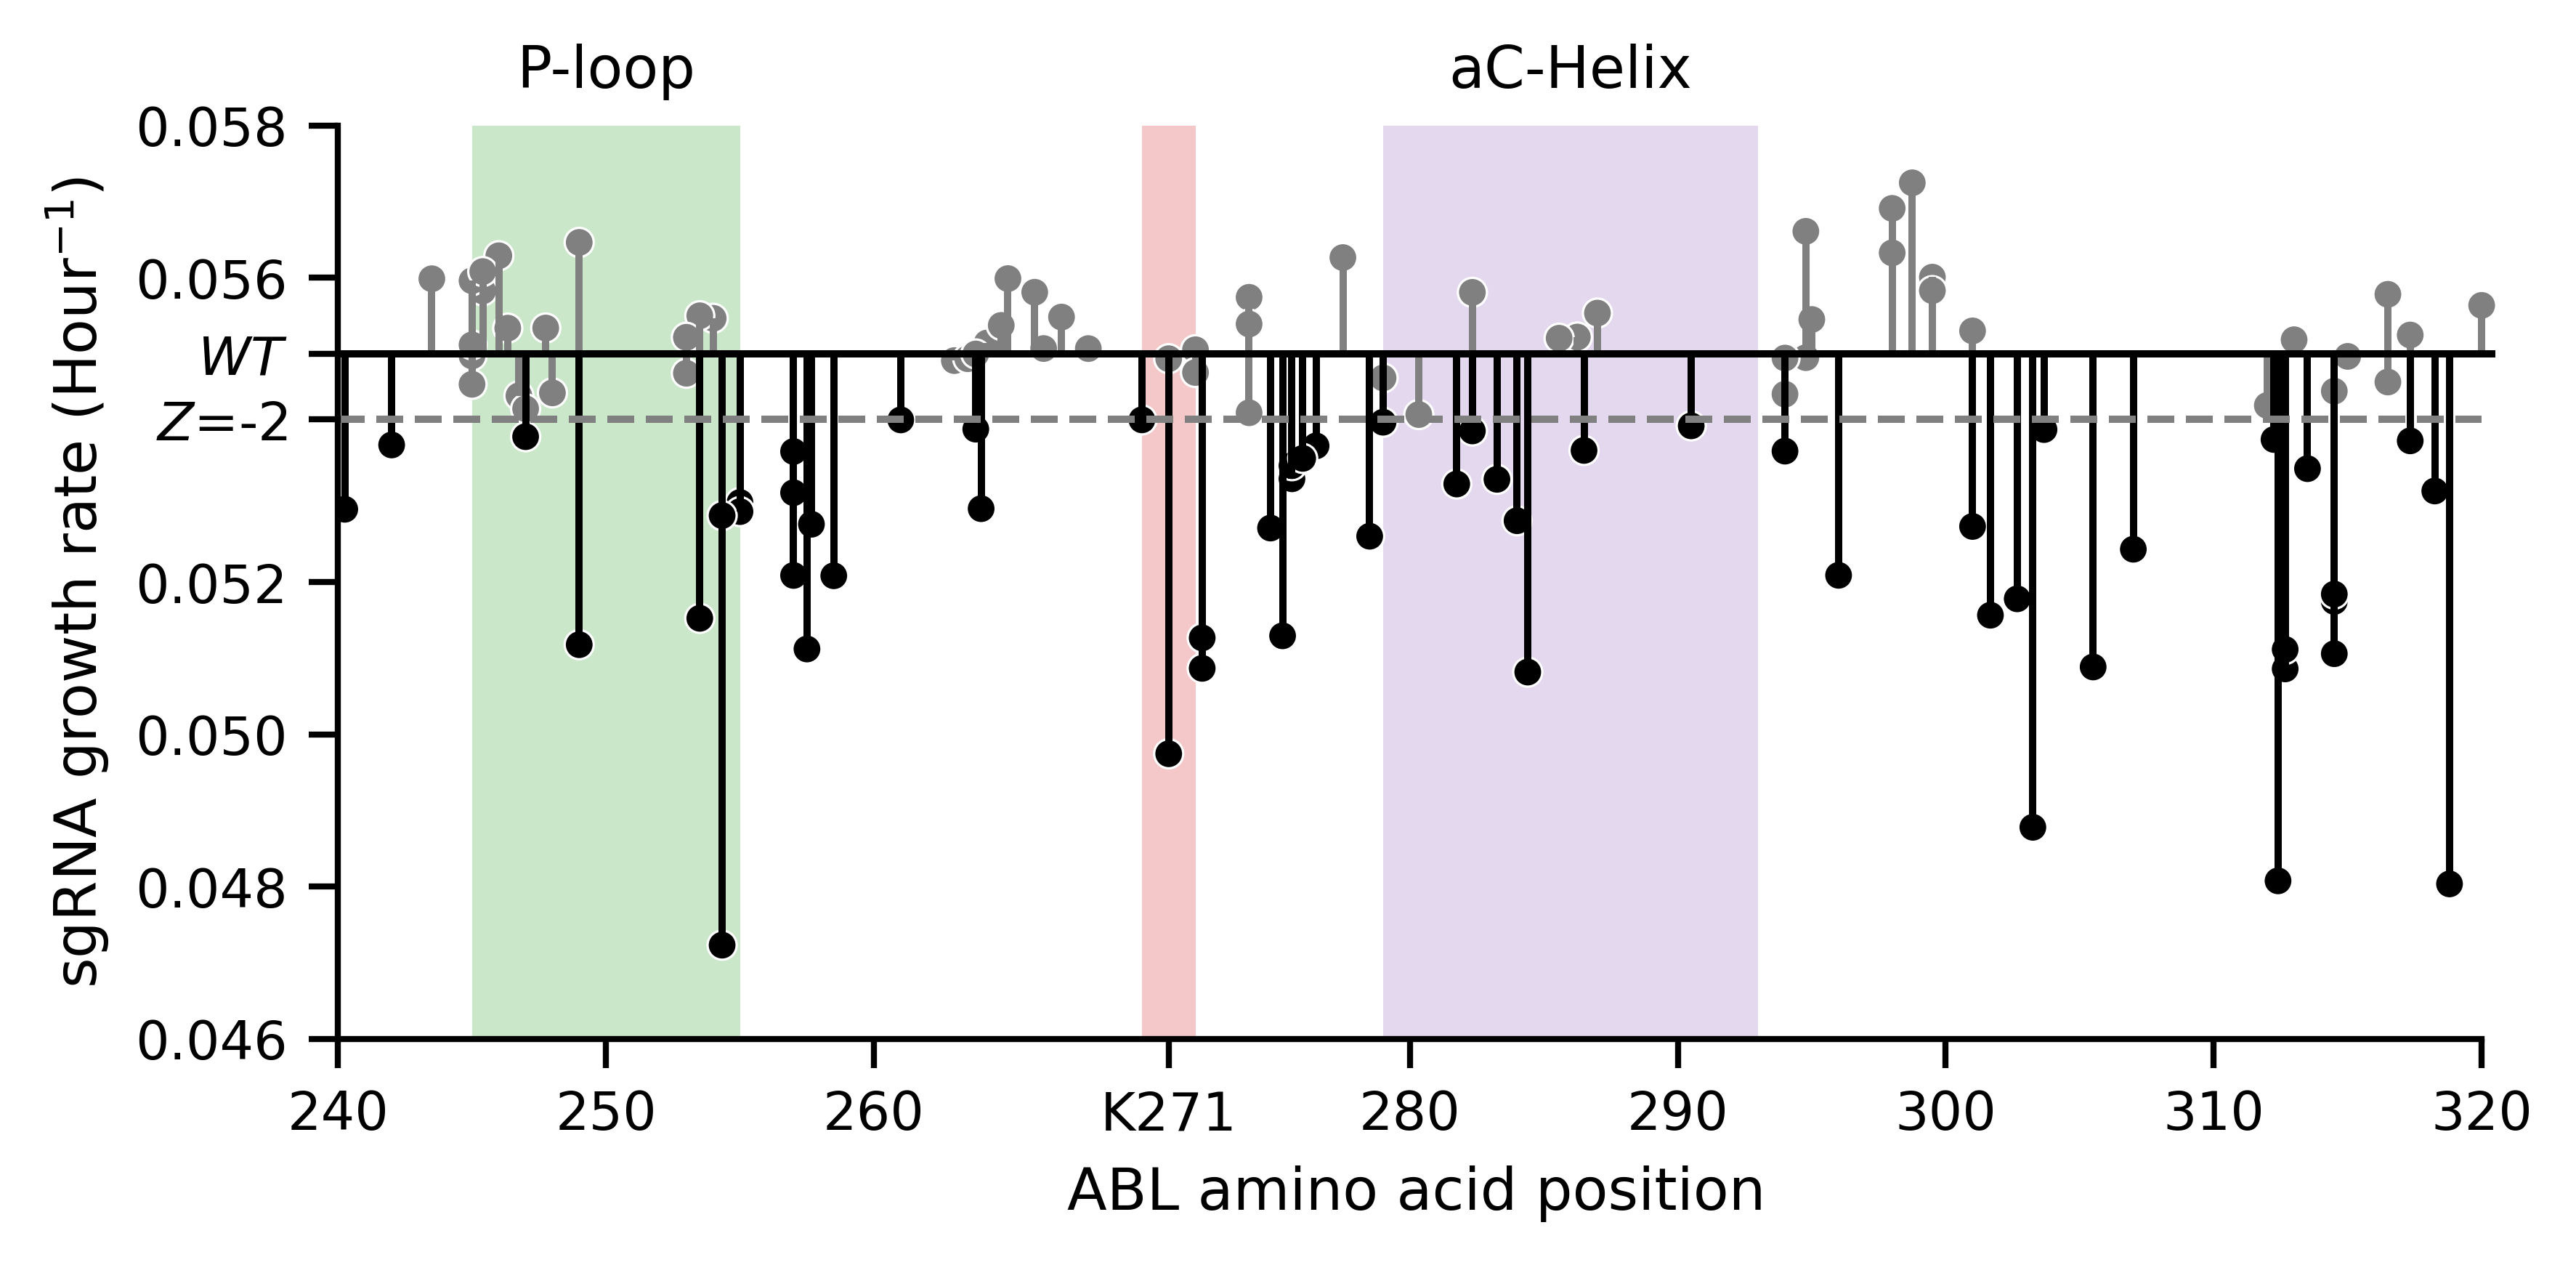

In [45]:
#Update to only missesnse muts
ABE_D0_pred_dedup_kinase_Missesnse['Hit'] = ABE_D0_pred_dedup_kinase_Missesnse['ABE_growthrate'] < SD2
ABE_D0_Mis2 = ABE_D0_pred_dedup_kinase_Missesnse.loc[ABE_D0_pred_dedup_kinase_Missesnse['Mean_ABL_AA'].between(240,320)]
ABE_D0_Mis2 = ABE_D0_Mis2.sort_values('Hit', ascending=True)
ABE_D0_Mis2_nonhits = ABE_D0_Mis2.loc[ABE_D0_Mis2['Hit']==False]
ABE_D0_Mis2_hits = ABE_D0_Mis2.loc[ABE_D0_Mis2['Hit']==True]


Kinase_Info = [['P-loop', 245,255 , 250, sns.color_palette()[2]], 
               ['',270, 272, 271, sns.color_palette()[3]], 
               ['aC-Helix',279, 293, 286, sns.color_palette()[4]]]

plt.figure(figsize=(6,3), dpi=600)
lollipop = sns.scatterplot(x='Mean_ABL_AA',y='ABE_growthrate', hue='Hit', palette=['black', 'grey'],
                           data=ABE_D0_Mis2.sort_values('Hit', ascending=True), legend=False, hue_order=[True,False], )
lollipop.set(xlabel='ABL amino acid position', ylabel='sgRNA growth rate (Hour$^{-1}$)', ylim=[0.046, 0.058], xlim=[240, 320.5])
plt.vlines(ABE_D0_Mis2_nonhits['Mean_ABL_AA'], 0.055, ABE_D0_Mis2_nonhits['ABE_growthrate'], color='grey')
plt.vlines(ABE_D0_Mis2_hits['Mean_ABL_AA'], 0.055, ABE_D0_Mis2_hits['ABE_growthrate'], color='black')
plt.hlines(0.055, 240, 320.5, linestyles="-", color='black')
plt.hlines(SD2,240,320, linestyles="--", color='grey')
for name, start, end, mid, color in Kinase_Info:
    plt.axvspan(start, end, color=color, alpha=0.25, ec=None, zorder=0)
    lollipop.text(mid, 0.0585, name, horizontalalignment='center')

lollipop.set_xticks([240, 250, 260, 271, 280, 290, 300, 310,320], [240, 250, 260, 'K271', 280, 290, 300, 310,320])
lollipop.set_yticks([0.046,0.048,0.050,0.052,SD2,0.055,0.056,0.058], [0.046,0.048,'0.050',0.052, '$\it{Z}$=-2',  '$\it{WT}$',0.056,0.058])
sns.despine(trim=True)
plt.tight_layout()
lollipop.get_figure().savefig("ABE Lollipop0614.svg" , transparent=True) 

In [46]:
ABE_D0_Mis2.sort_values('Hit')

,sgName,ABE_growthrate,Mean_AA_Number,Final_Class,Mean_ABL_AA,Hit
7994,BCR2_357,0.056006,1199.500000,Missense,299.500000,False
5397,BCRABL_1782,0.055337,1147.750000,Missense,247.750000,False
9103,BCR2_1099,0.055300,1201.000000,Missense,301.000000,False
3634,BCRABL_1875,0.055245,1217.333333,Missense,317.333333,False
3338,BCRABL_1807,0.055141,1164.222222,Missense,264.222222,False
...,...,...,...,...,...,...
1924,BCRABL_1793,0.047229,1154.333333,Missense,254.333333,True
1713,BCRABL_1868,0.051058,1214.500000,Missense,314.500000,True
1662,BCRABL_1797,0.053174,1157.000000,Missense,257.000000,True
6901,BCRABL_1826,0.053625,1176.000000,Missense,276.000000,True


### Essential Domains

In [47]:
sgRNA_pred = pd.read_csv('BCRABBL NG sgRNA Predicted Mutagenesis Classed Labeled with Final Class 20240130 2to12.csv')
sgRNA_pred_ABE = sgRNA_pred.loc[(sgRNA_pred['Type']=='ABE')&(sgRNA_pred['RefSeq cDNA']==True)&(sgRNA_pred['Final_Class']=='Missense')]
ABE_D0_pred = pd.merge(DESeq2_DF_FC[['sgName', 'ABE_D0']], sgRNA_pred_ABE, on='sgName')
ABE_D0_pred['ABE_growthrate'] = np.log(ABE_D0_pred['ABE_D0']*np.exp(0.055*9*24))/(9*24)
ABE_D0_pred_dedup = ABE_D0_pred[['sgName', 'ABE_growthrate','Mean_AA_Number', 'Final_Class']].drop_duplicates()

In [48]:
len(ABE_D0_pred_dedup)

2871

In [49]:
ABE_D0_pred_dedup['ABE_GR_binary'] = ABE_D0_pred_dedup['ABE_growthrate'] < SD4
ABE_D0_pred_dedup = ABE_D0_pred_dedup.sort_values('Mean_AA_Number')

In [50]:
ABE_roll = ABE_D0_pred_dedup[['Mean_AA_Number', 'ABE_GR_binary']].rolling(40, on='Mean_AA_Number').mean()

In [51]:
PFam = pd.read_csv('PFAM_domains.csv')
PFam

,ID,Domain,Start,End,Name,Color,TextLocation
0,PF09036,Bcr-Abl oncoprotein oligomerisation domain,3,75,CC,lime,39
1,PF00621,RhoGEF domain,503,689,DH,gold,596
2,SSF50729,PH domain,706,868,PH,cyan,787
3,cd11850,SH3_Abl,966,1019,SH3,skyblue,970
4,PF00017,SH2 domain,1028,1103,SH2,magenta,1080
5,G3DSA:1.10.510.10:FF:002964,Tyrosine-protein kinase,1137,1402,Kinase,crimson,1270
6,PF08919,F-actin binding,1927,2031,FAB,grey,1979


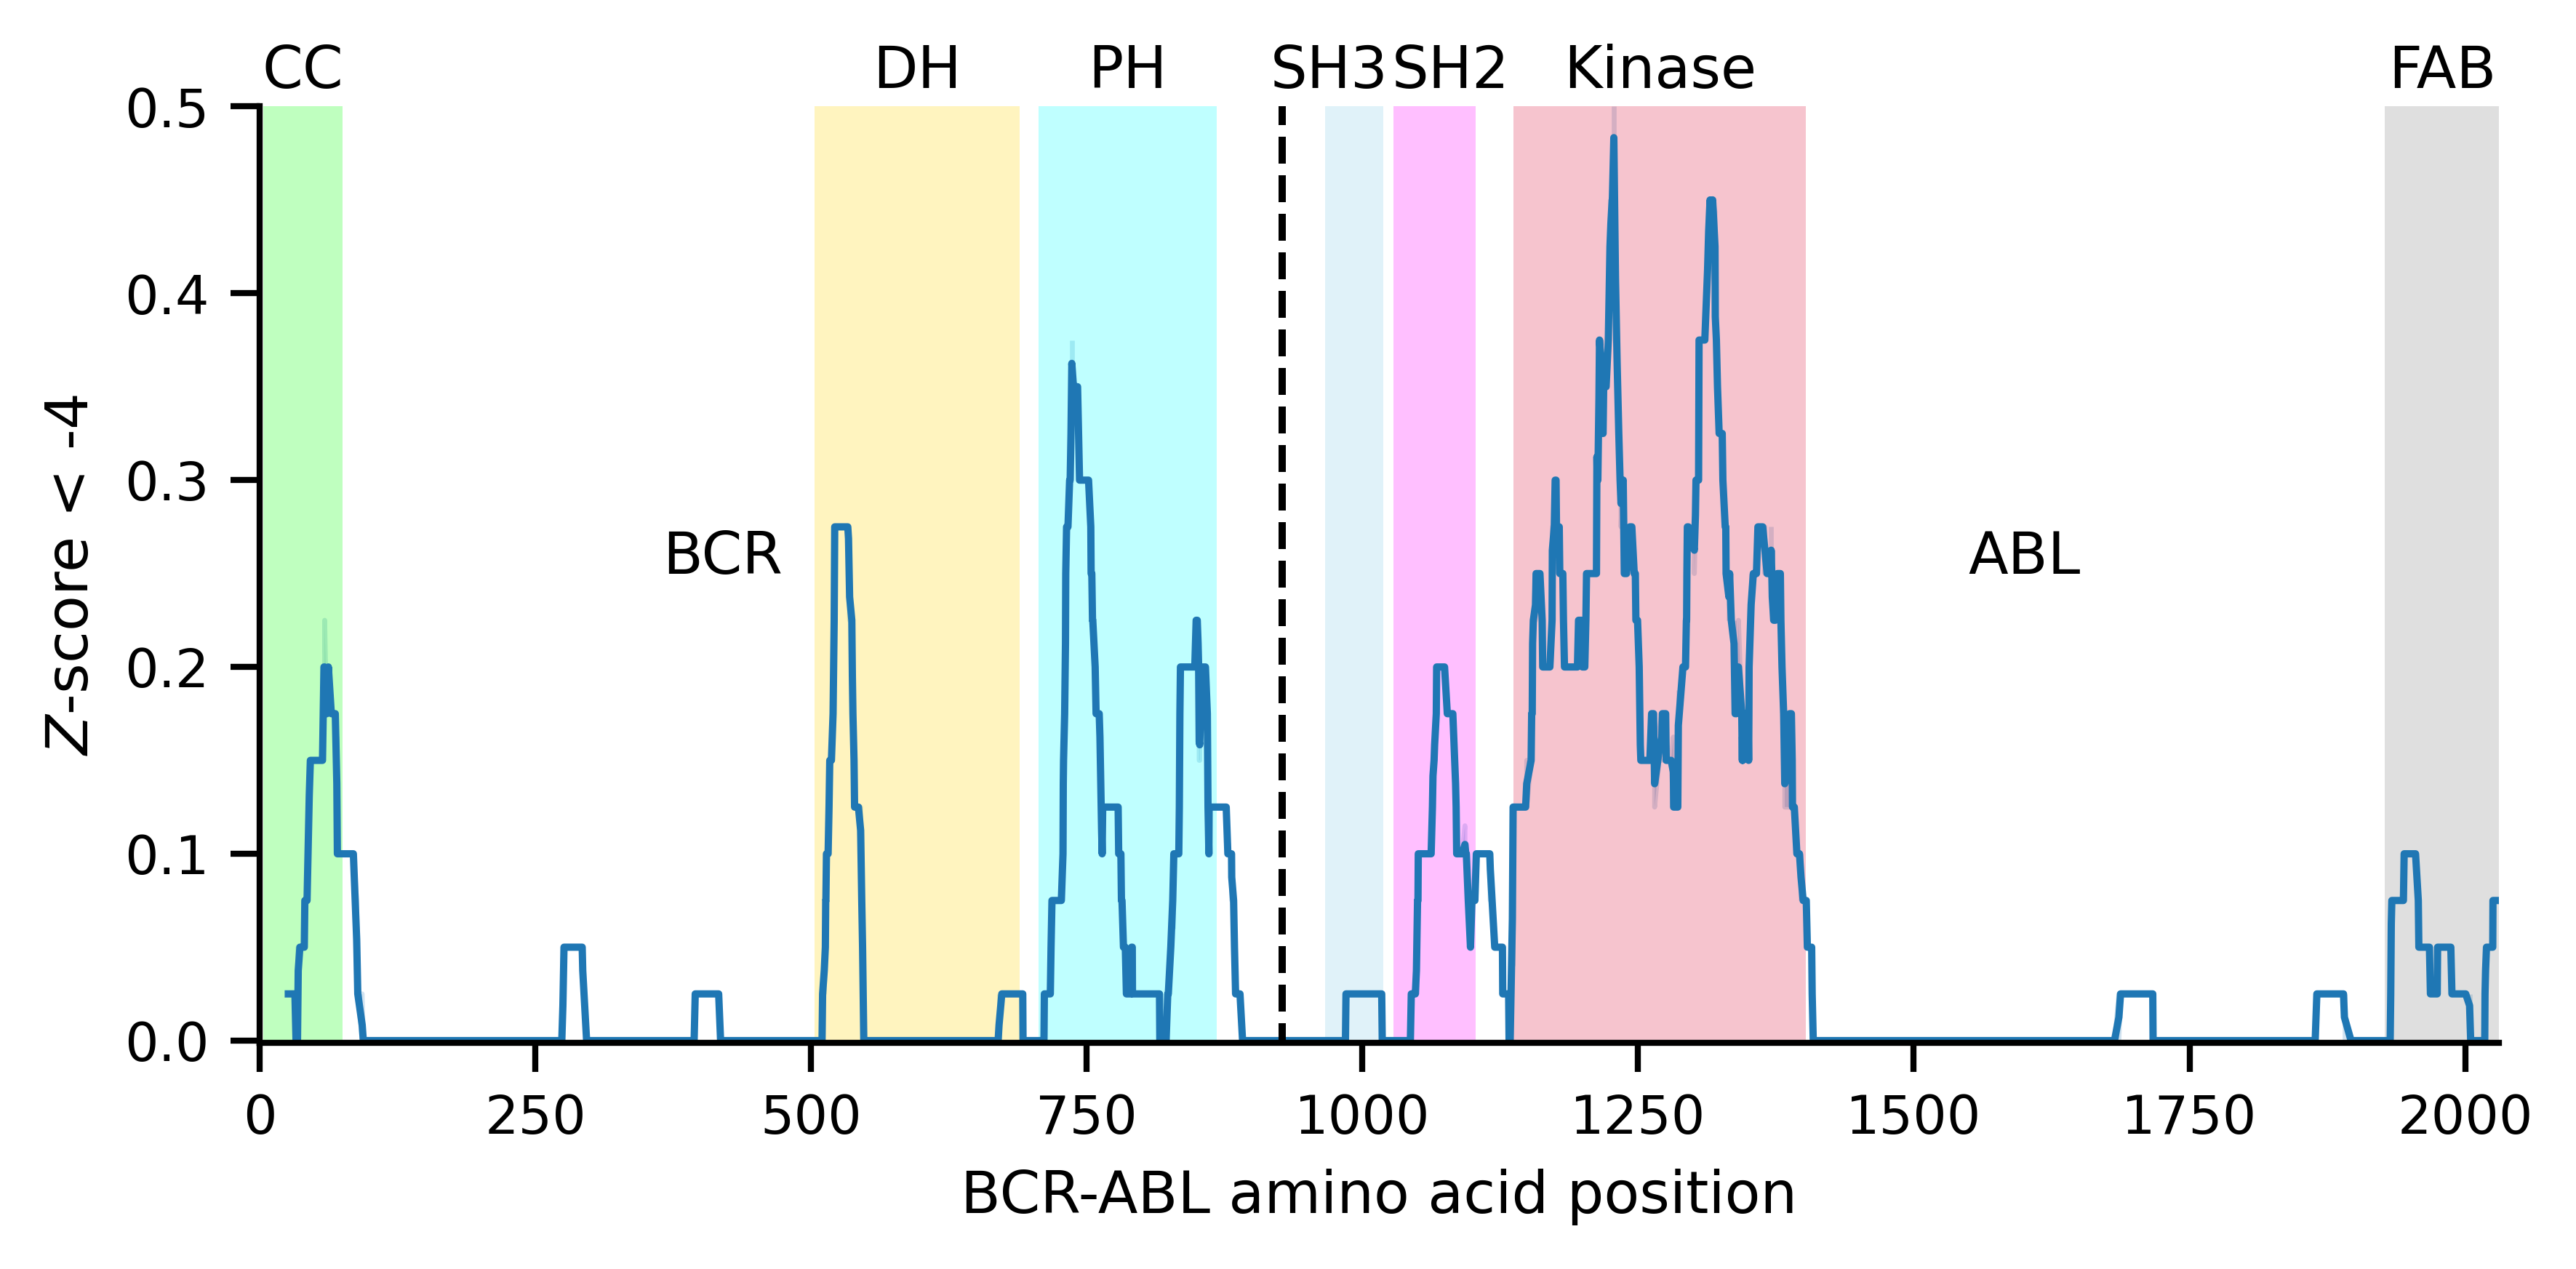

In [52]:
plt.figure(figsize=(6,3), dpi=600)
roll_plot = sns.lineplot(x='Mean_AA_Number', y='ABE_GR_binary', data=ABE_roll)
roll_plot.set(xlabel='BCR-ABL amino acid position', ylabel='$\it{Z}$' +'-score < -4', ylim=[-0.001, 0.50],  xlim=[0, 2030.5])
for ID, Domain, Start, End, Name, Color, TextLoc in PFam.values:
    plt.axvspan(Start, End, color=Color, alpha=0.25, ec=None)
    roll_plot.text(TextLoc, 0.51, Name, horizontalalignment='center')
plt.vlines(927.5, -0.005,0.50, linestyles="--", color='black')
roll_plot.text(420, 0.25, 'BCR', horizontalalignment='center')
roll_plot.text(1600, 0.25, 'ABL', horizontalalignment='center')
sns.despine()
plt.tight_layout()
roll_plot.get_figure().savefig("ABE ImportantDomains SD4 240613.svg", transparent=True) 